In [3]:
!pip install pandas requests rdkit ipywidgets tqdm openai faiss-cpu transformers sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


FileUpload(value={}, accept='.csv', description='Upload Compound Data (.csv)')

FileUpload(value={}, accept='.csv', description='Upload SMILES Data (.csv)')

IntProgress(value=0, bar_style='info', description='Progress:')

Label(value='')

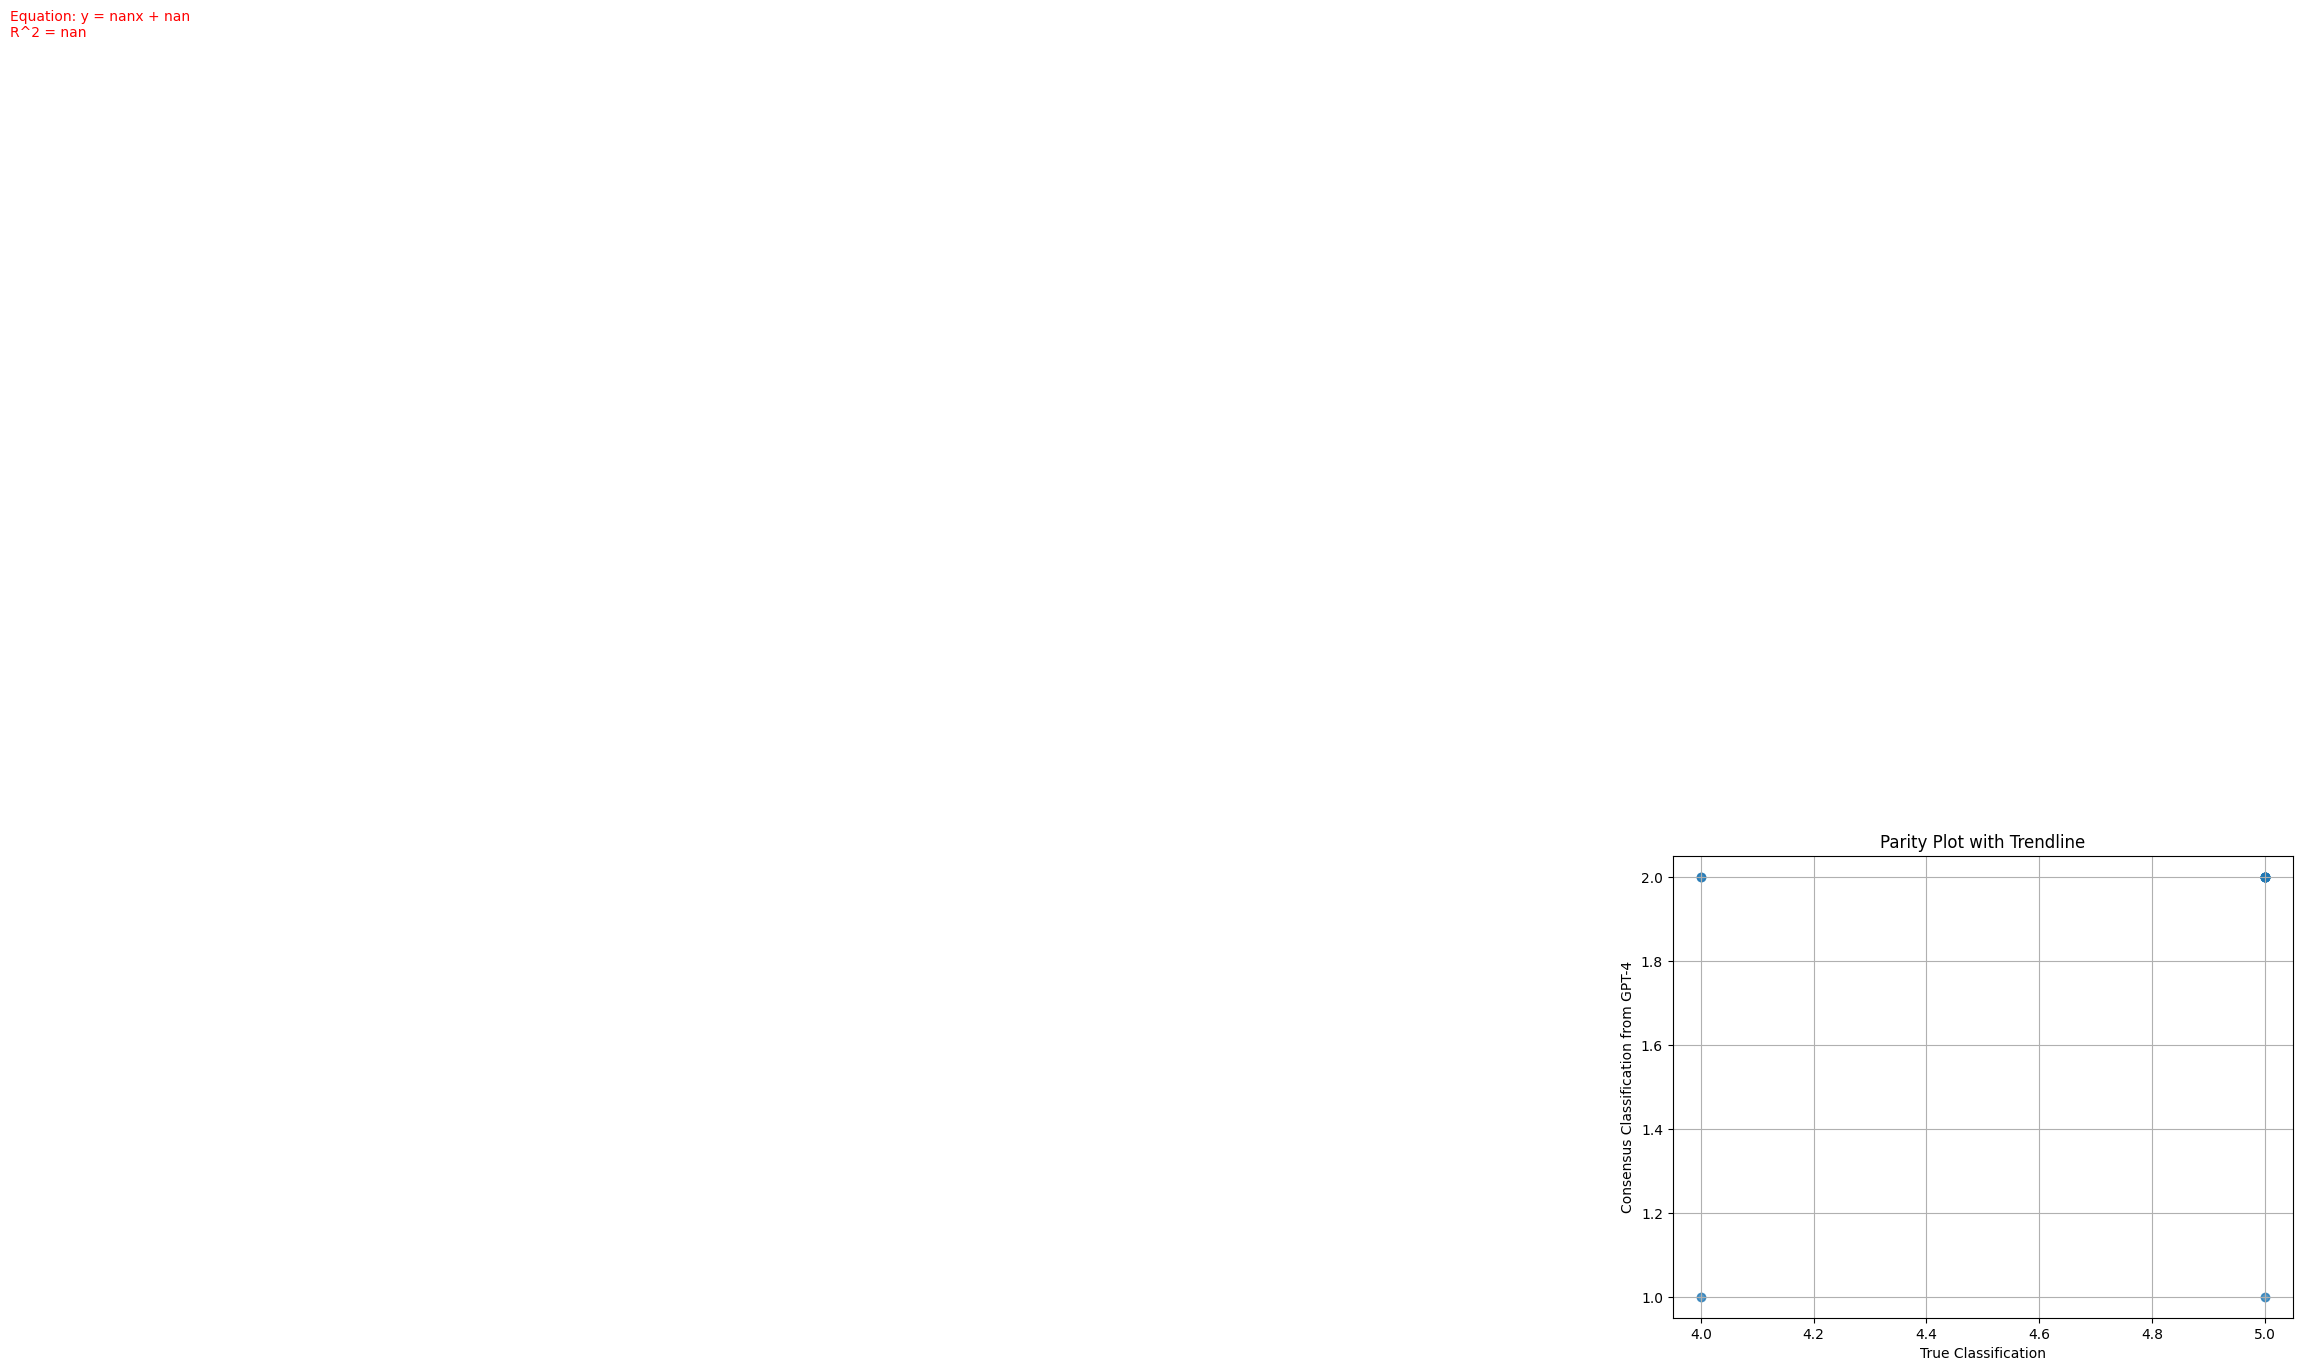

In [6]:
import pandas as pd
import faiss
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets as widgets
from IPython.display import display, HTML
import io
import time
import matplotlib.pyplot as plt
import os
from sentence_transformers import SentenceTransformer
import openai
from scipy.stats import linregress


# Install necessary libraries
!pip install openai==0.28

# Set your OpenAI API key
openai.api_key = 'sk-proj-3emuQGqpQTAjMQF9HwWST3BlbkFJ4aeWLUD7OV674KHSkOd8'

# Load a pre-trained embedding model from Hugging Face
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Function to generate embeddings using a local model
def generate_embedding(text):
    return model.encode([text])[0]

# Function to generate Morgan fingerprint
def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return list(fingerprint)
    else:
        return None

# Function to get LD50 category
def get_ld50_category(ld50):
    if ld50 <= 5:
        return 1
    elif 5 < ld50 <= 50:
        return 2
    elif 50 < ld50 <= 300:
        return 3
    elif 300 < ld50 <= 2000:
        return 4
    elif 2000 < ld50 <= 5000:
        return 5
    else:
        return None

# Function to create the FAISS index from the compound data
def create_faiss_index(compound_data_file):
    progress_label.value = "Creating FAISS index..."
    df = pd.read_csv(io.StringIO(compound_data_file['content'].decode('utf-8')))

    # Generate Morgan fingerprints
    df['MorganFingerprint'] = df['SMILES'].apply(lambda x: generate_morgan_fingerprint(x))

    # Define the sentence template
    sentence_template = "{Compound_name} with CASRN {CASRN} has an LD50 of {LD50} mg/kg, is classified as GHS class {GHS_class}, has InChIKey {InChIKey}, and Morgan fingerprint {FingerprintString}."

    # Convert Morgan fingerprints to binary strings for inclusion in sentences
    df['FingerprintString'] = df['MorganFingerprint'].apply(lambda x: ''.join(map(str, x)) if x is not None else 'None')

    # Generate sentences from the DataFrame
    df['Sentence'] = df.apply(lambda row: sentence_template.format(
        Compound_name=row['Compound_name'],
        CASRN=row['CASRN'],
        LD50=row['LD50'],
        GHS_class=row['GHS class'],
        InChIKey=row['InChIKey'],
        FingerprintString=row['FingerprintString']
    ), axis=1)

    # Convert fingerprints to numpy arrays
    fingerprints = np.array([np.array(fp, dtype=np.float32) if fp is not None else np.zeros(2048) for fp in df['MorganFingerprint']])

    # Generate embeddings for the compounds
    sentences = df['Sentence'].tolist()
    embeddings = [generate_embedding(sentence) for sentence in sentences]
    embeddings = np.array(embeddings).astype('float32')

    # Initialize the FAISS index
    dimension = embeddings.shape[1] + fingerprints.shape[1]
    index = faiss.IndexFlatL2(dimension)

    # Combine embeddings and fingerprints
    combined_data = np.hstack((embeddings, fingerprints))

    # Add combined data to the index
    index.add(combined_data)

    # Save the index to disk
    faiss.write_index(index, "vector_index.index")
    progress_label.value = "FAISS index created and stored successfully."

    # Save the InChIKeys for reference
    np.save("inchikeys.npy", df['InChIKey'].to_numpy())
    progress_label.value = "InChIKeys saved."

    # Save the original DataFrame for reference
    df.to_csv("compounds_data.csv", index=False)
    progress_label.value = "Compound data saved."

# Function to process the uploaded SMILES file and generate predictions
def process_smiles_file(uploaded_file):
    progress_label.value = "Reading and processing the SMILES file..."
    content = uploaded_file['content']
    df_smiles = pd.read_csv(io.StringIO(content.decode('utf-8')))

    # Load the saved FAISS index
    if not os.path.exists("vector_index.index"):
        progress_label.value = "FAISS index file not found."
        return

    index = faiss.read_index("vector_index.index")

    # Load the InChIKeys and original DataFrame
    if not os.path.exists("inchikeys.npy") or not os.path.exists("compounds_data.csv"):
        progress_label.value = "InChIKeys or compound data file not found."
        return

    inchikeys = np.load("inchikeys.npy", allow_pickle=True)
    df_compounds = pd.read_csv("compounds_data.csv")

    true_classes = []
    predicted_classes = []

    for smiles in df_smiles['SMILES']:
        progress_label.value = f"Processing SMILES: {smiles}"

        # Generate Morgan fingerprint for the input SMILES
        fingerprint = generate_morgan_fingerprint(smiles)
        if fingerprint is None:
            print(f"Invalid SMILES string: {smiles}")
            continue

        # Convert fingerprint to numpy array
        fingerprint_array = np.array(fingerprint, dtype=np.float32)

        # Generate the embedding for the input SMILES
        sentence_template = "Compound with SMILES {} and Morgan fingerprint {}.".format(smiles, ''.join(map(str, fingerprint)))
        embedding = generate_embedding(sentence_template)
        embedding_array = np.array(embedding, dtype=np.float32)

        # Combine the embedding and fingerprint
        query_vector = np.hstack((embedding_array, fingerprint_array)).reshape(1, -1)

        # Search for the nearest compounds
        distances, indices = index.search(query_vector, 5)

        # Extract the nearest compounds
        nearest_compounds = df_compounds.iloc[indices[0]]
        compound_info = nearest_compounds[['Compound_name', 'LD50', 'GHS class']]

        # Create the prompt for GPT-4
        prompt = "You are an expert in chemical toxicology and your job is to take the 5 compounds that are the most similar to an unknown compound and provide the following:\n\n"
        prompt += compound_info.to_string(index=False, header=False)
        prompt += "\n\nThen, using that information, predict if the unknown compound is highly toxic, toxic, moderately toxic, slightly toxic, or non-toxic."

        # Send the prompt to GPT-4
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in chemical toxicology and your job is to take the 5 compounds that are the most similar to a unknown compound and provide the following:\n\nCompound name\nLD50\nGHS Class\n\nThen, using that information, predict if the unknown compound is highly toxic, toxic, moderately toxic, slightly toxic, or non-toxic."},
                {"role": "user", "content": prompt}
            ]
        )

        prediction = response['choices'][0]['message']['content'].strip().lower()
        if "highly toxic" in prediction:
            predicted_classes.append(1)
        elif "toxic" in prediction:
            predicted_classes.append(2)
        elif "moderately toxic" in prediction:
            predicted_classes.append(3)
        elif "slightly toxic" in prediction:
            predicted_classes.append(4)
        elif "non-toxic" in prediction:
            predicted_classes.append(5)
        else:
            predicted_classes.append(None)

        true_classes.append(get_ld50_category(nearest_compounds['LD50'].mean()))

    # Create a DataFrame with true and predicted classes
    results_df = pd.DataFrame({
        'True Class': true_classes,
        'Predicted Class': predicted_classes
    })

    # Generate parity plot
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df['True Class'], results_df['Predicted Class'], alpha=0.5)

    # Fit a linear trendline using scipy.stats.linregress
    slope, intercept, r_value, p_value, std_err = linregress(results_df['True Class'], results_df['Predicted Class'])
    plt.plot(results_df['True Class'], slope*results_df['True Class'] + intercept, color='red')

    # Display the equation and R^2 value
    plt.text(1, 4, f'Equation: y = {slope:.2f}x + {intercept:.2f}\nR^2 = {r_value**2:.2f}', color='red')

    plt.xlabel('True Classification')
    plt.ylabel('Consensus Classification from GPT-4')
    plt.title('Parity Plot with Trendline')
    plt.grid(True)
    plt.show()

# Create the file upload widget for compound data
upload_compound_data_widget = widgets.FileUpload(accept='.csv', multiple=False, description="Upload Compound Data (.csv)")

# Define the function to handle the compound data upload
def handle_upload_compound_data(change):
    for filename, file_info in upload_compound_data_widget.value.items():
        create_faiss_index(file_info)

# Display the compound data upload widget
upload_compound_data_widget.observe(handle_upload_compound_data, names='value')
display(upload_compound_data_widget)

# Create the SMILES file upload widget
upload_smiles_widget = widgets.FileUpload(accept='.csv', multiple=False, description="Upload SMILES Data (.csv)")

# Define the function to handle the SMILES file upload
def handle_upload_and_process_smiles(change):
    for filename, file_info in upload_smiles_widget.value.items():
        process_smiles_file(file_info)

# Display the SMILES upload widget
upload_smiles_widget.observe(handle_upload_and_process_smiles, names='value')
display(upload_smiles_widget)

# Create progress bar and label
progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='info',
    orientation='horizontal'
)
progress_label = widgets.Label(value="")

# Display progress bar and label
display(progress_bar, progress_label)